# **Here Importing the Eseantial libraries **

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import os
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

# Load the Lables of the images from train.csv file 

In [22]:
dataframe = pd.read_csv('/kaggle/input/human-protein-atlas-image-classification/train.csv')
dataframe.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


 * Defining the input shape of 1st input layer 
 * decalare the batch size
 * save the path of train images in the variable 'path_to_train'

In [23]:
INPUT_SHAPE = (512, 512, 3)
BATCH_SIZE = 16
path_to_train = '/kaggle/input/human-protein-atlas-image-classification/train/'

 Adding the column with the name of complete_path and load the full path of each image on csv 

In [24]:
dataframe["complete_path"] = path_to_train + dataframe["Id"]
dataframe.head(5)

,Id,Target,complete_path
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,/kaggle/input/human-protein-atlas-image-classi...
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,/kaggle/input/human-protein-atlas-image-classi...
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,/kaggle/input/human-protein-atlas-image-classi...
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,/kaggle/input/human-protein-atlas-image-classi...
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,/kaggle/input/human-protein-atlas-image-classi...


#  Visualizing the pictures



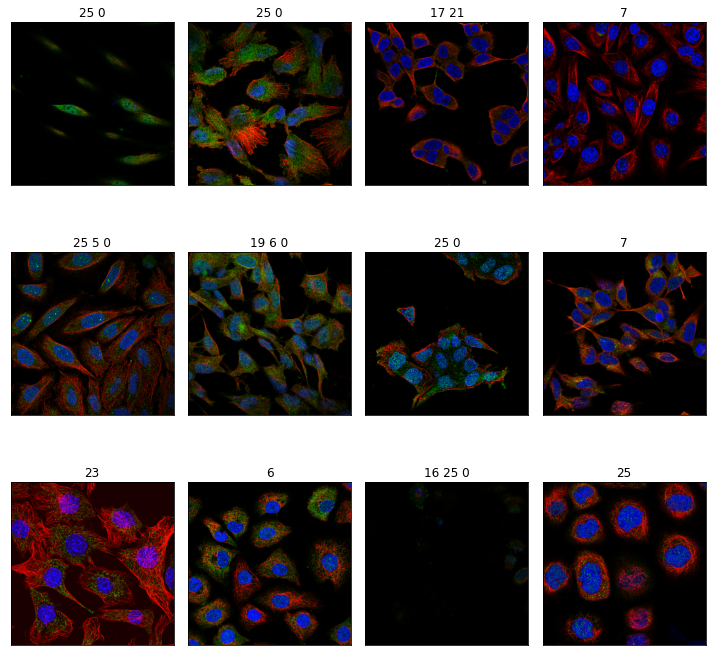

In [25]:
import random
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for i in range(3):
    for j in range(4):
        idx = random.randint(0, dataframe.shape[0])
        row = dataframe.iloc[idx,:]
        path = row.complete_path
        red = np.array(Image.open(path + '_red.png'))
        green = np.array(Image.open(path + '_green.png'))
        blue = np.array(Image.open(path + '_blue.png'))
        im = np.stack((
                red,
                green,
                blue),-1)
        axes[i][j].imshow(im)
        axes[i][j].set_title(row.Target)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
fig.tight_layout()
fig.show(5);

Spliting the data into parts train and val(valiation)

In [26]:
train, val = train_test_split(dataframe, test_size=0.2, random_state=42)


In [27]:
print(f'Shape of train: {train.shape}')
print(f'Shape of val: {val.shape}')

Shape of train: (24857, 3)
Shape of val: (6215, 3)


Cleaning the data for better results 

In [28]:
def get_clean_data(df):
    targets = []
    paths = []
    for _, row in df.iterrows():
        target_np = np.zeros((28))
        t = [int(t) for t in row.Target.split()]
        target_np[t] = 1
        targets.append(target_np)
        paths.append(row.complete_path)
    return np.array(paths), np.array(targets)

In [29]:
train_path, train_target = get_clean_data(train)
val_path, val_target = get_clean_data(val)

printing train and val path and target



In [30]:
print(f'Train path shape: {train_path.shape}')
print(f'Train target shape: {train_target.shape}')
print(f'Val path shape: {val_path.shape}')
print(f'Val target shape: {val_target.shape}')


Train path shape: (24857,)
Train target shape: (24857, 28)
Val path shape: (6215,)
Val target shape: (6215, 28)


creating datasets from cleaned data


In [31]:
train_data = tf.data.Dataset.from_tensor_slices((train_path, train_target))
val_data = tf.data.Dataset.from_tensor_slices((val_path, val_target))

Experimental API for building input pipelines.



In [32]:
def load_data(path, target):
    red = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_red.png'), channels=1), [2])
    blue = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_blue.png'), channels=1), [2])
    green = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_green.png'), channels=1), [2])
    #yellow=tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_yellow.png'), channels=1), [2])
    img = tf.stack((
                red,
                green,
                blue), axis=2)
    return img, target

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.map(load_data, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(load_data, num_parallel_calls=AUTOTUNE)

Adjust the contrast of an image or images by a random factor.



In [33]:
def image_augment(img, target):
    img = tf.image.random_contrast(img, lower=0.3, upper=2.0)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, target
    
train_data = train_data.map(image_augment, num_parallel_calls=AUTOTUNE)

Better performance with the tf.data API


In [34]:
train_data_batches = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_data_batches = val_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Building the Model Architecture 

Using transfer learning and fine tuning on InceptionResNetV2

In [35]:
inception_model = applications.InceptionResNetV2(include_top=False, weights='imagenet')

inception_model.trainable = False

input_layer = Input(shape=INPUT_SHAPE)
x = inception_model(input_layer)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(28, activation='sigmoid')(x)
model = Model(input_layer, output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 301056)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 301056)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               154141184 
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1436

model compilation 

In [36]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

Now finally fit the model for trianing ...

In [37]:
history = model.fit(train_data_batches, validation_data = val_data_batches,steps_per_epoch = 50, epochs=10)

Epoch 1/10
50/50 [==============================] - 137s 3s/step - loss: 1569.9841 - binary_accuracy: 0.8556 - val_loss: 0.8211 - val_binary_accuracy: 0.9351
Epoch 2/10
50/50 [==============================] - 123s 3s/step - loss: 0.7318 - binary_accuracy: 0.9393 - val_loss: 0.6799 - val_binary_accuracy: 0.9399
Epoch 3/10
50/50 [==============================] - 123s 3s/step - loss: 0.6637 - binary_accuracy: 0.9404 - val_loss: 0.6500 - val_binary_accuracy: 0.9401
Epoch 4/10
50/50 [==============================] - 123s 3s/step - loss: 0.6356 - binary_accuracy: 0.9390 - val_loss: 0.6271 - val_binary_accuracy: 0.9402
Epoch 5/10
50/50 [==============================] - 123s 3s/step - loss: 0.6139 - binary_accuracy: 0.9395 - val_loss: 0.6067 - val_binary_accuracy: 0.9404
Epoch 6/10
50/50 [==============================] - 124s 3s/step - loss: 0.5878 - binary_accuracy: 0.9392 - val_loss: 0.5882 - val_binary_accuracy: 0.9404
Epoch 7/10
50/50 [==============================] - 124s 3s/step - 

Visualizing the Results 

In [38]:
model.save('InceptionV2.h5')

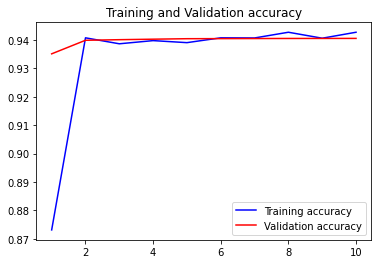

<Figure size 432x288 with 0 Axes>

In [39]:
binary_accuracy=history.history['binary_accuracy']
val_binary_accuracy=history.history['val_binary_accuracy']
epochs=range(1,len(binary_accuracy)+1)
plt.plot(epochs,binary_accuracy,'b',label='Training accuracy')  
plt.plot(epochs,val_binary_accuracy,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

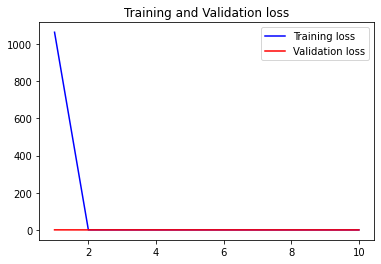

<Figure size 432x288 with 0 Axes>

In [40]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(binary_accuracy)+1)
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()
plt.show()